# OOP-Variante (V)

Stellen Sie sich eine Grafik wie eine **Baugruppe** vor: Sie setzt sich aus **Unterbaugruppen** zusammen, diese wiederum aus weiteren Unterbaugruppen und am Ende aus **Einzelteilen**.


## Ziel: „Plotbereich/Hintergrund mit Logo“ als Variante

Wir möchten eine Variante des Plotbereichs (vereinfacht: „Hintergrund“) haben, die **zusätzlich ein Logo enthält** – und zwar so, dass Anwender:innen weiterhin „ganz normal“ plotten können.

Aus Wrapper-Sicht heißt das: Wir nehmen den bereits vorhandenen Plotbereich und **fügen ein Element hinzu** (das Logo). In der Baugruppen-Logik bedeutet das: Wir bauen aus einer vorhandenen Unterbaugruppe eine **Variante mit zusätzlichem Anbauteil**.

- normaler Plotbereich (ohne Logo)
- Plotbereich mit Logo (als Variante)

Wichtig ist dabei: **Die Bedienoberfläche bleibt gleich** (Sie plotten wie gewohnt), aber eine interne Komponente wird als Variante ausgetauscht/erweitert, sodass das zusätzliche Verhalten (Logo) „automatisch“ dazukommt.

## Wie könnte man das erreichen?

Matplotlib ist – wie viele Bibliotheken – wie ein System aus **Baugruppen** aufgebaut. Für uns reicht ein einfaches „enthält“-Bild, damit man weiß, *wo* man ansetzt:

- **Figure** (Gesamtbaugruppe): die ganze Abbildung
  - enthält ein oder mehrere **Axes** (Baugruppen): einzelne Plotbereiche
    - enthalten viele **Artists** (Einzelteile): Linien, Texte, Rahmen, Bilder, …

Der „Hintergrund/Plotbereich“ heißt in Matplotlib `Axes`. Das Logo ist dabei einfach ein weiteres Einzelteil (ein Bild-„Artist“), das am Plotbereich hängt.

### OOP-Kern: Vererbung (Variante, die weiterhin „passt“)

Damit unser „Plotbereich mit Logo“ wirklich ein Plotbereich bleibt und überall passt, wo Matplotlib ein `Axes` erwartet, bauen wir die Variante als **neue Klasse, die von `Axes` erbt**. Das ist ein zentrales Verfahren in der Objektorientierung: Eine neue Baugruppe entsteht aus einer vorhandenen – mit **gleichen Anschlüssen nach außen**, aber zusätzlichem Innenleben.

### Architektur-Kern: Registrierung (wie Matplotlib die neue Klasse kennt)
Woher weiß Matplotlib nun, dass es diese neue Klasse gibt? Dafür gibt es einen **Erweiterungspunkt** in der Bibliothek: Die neue Klasse wird in einer Registry „angemeldet“ (registriert), sodass Matplotlib sie bei Bedarf erzeugen kann. Das ist eher ein Thema von **Software-Architektur** (Erweiterbarkeit/Plugins) als von OOP selbst – hängt aber mit OOP zusammen, weil Matplotlib seine Baugruppen als austauschbare Objekte organisiert.

Wie man Vererbung und Registrierung im Code findet, zeigt das folgende Beispiel (Details sind exemplarisch; wichtig ist die Idee).

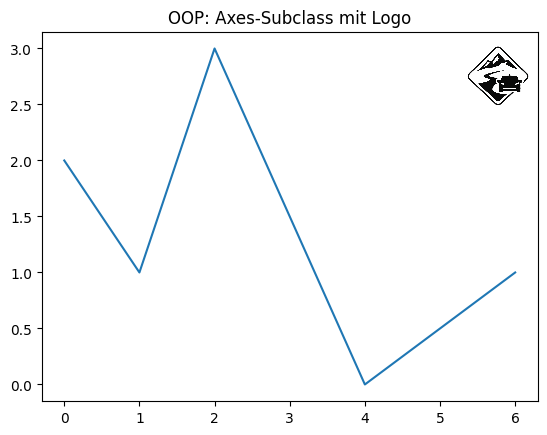

In [1]:
from io import BytesIO
from urllib.request import urlopen

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.projections import register_projection

LOGO_URL = "https://github.com/fk03ingenieursinformatik/ingenieurinformatik-buch-deploy/blob/master/img/logo-mini.png?raw=true"


def load_logo(url: str):
    """Lädt das Logo von einer URL (PNG) als Bildarray."""
    with urlopen(url, timeout=10) as response:
        data = response.read()
    return mpimg.imread(BytesIO(data), format="png")


class LogoAxes(Axes):
    """Ein Matplotlib-Axes, das automatisch ein Logo einfügt."""

    name = "logo"

    def __init__(
        self,
        *args,
        logo_url: str = LOGO_URL,
        logo_zoom: float = 0.07,
        logo_xy=(0.92, 0.88),
        **kwargs,
    ):
        # Eigene Parameter speichern (nicht an Axes weiterreichen).
        self._logo_url = logo_url
        self._logo_zoom = logo_zoom
        self._logo_xy = logo_xy
        self._logo_artist = None

        super().__init__(*args, **kwargs)
        self._ensure_logo()

    def _ensure_logo(self):
        if self._logo_artist is not None:
            return

        logo = load_logo(self._logo_url)
        imagebox = OffsetImage(logo, zoom=self._logo_zoom)
        self._logo_artist = AnnotationBbox(
            imagebox, self._logo_xy, xycoords="axes fraction", frameon=False
        )
        self.add_artist(self._logo_artist)


register_projection(LogoAxes)
# Ab hier kennt Matplotlib unseren neuen Axes-Typ:
# fig.add_subplot(..., projection="logo") -> erzeugt ein LogoAxes-Objekt.


fig = plt.figure()
ax = fig.add_subplot(111, projection="logo", logo_url=LOGO_URL)
ax.plot([0, 1, 2, 4, 6], [2, 1, 3, 0, 1])
ax.set_title("OOP: Axes-Subclass mit Logo")

plt.show()

## Was haben wir gewonnen?

```{figure} ../../figs/11-object-oriented/logoaxes_diagram.png
---
width: 700px
name: fig-logoaxes-diagram
---
Überblick: `LogoAxes` erweitert `Axes` und wird als neue Projektion registriert.
```


In diesem Beispiel haben wir tatsächlich eine Komponente ausgetauscht: Statt eines normalen `Axes` verwenden wir ein `LogoAxes`.

- **Vererbung (OOP):** Die neue Baugruppe wird als Variante aus der vorhandenen abgeleitet. Im Code sehen Sie das an `class LogoAxes(Axes):` und daran, dass zuerst die Elternklasse aufgebaut wird (`super().__init__(...)`).
- **Registrierung (Architektur/Erweiterungspunkt):** Matplotlib muss wissen, dass es diese Variante gibt. Im Code ist das `register_projection(LogoAxes)` (inkl. Name `LogoAxes.name = "logo"`); die „Auswahl“ der Variante sieht man dann bei `fig.add_subplot(..., projection="logo", ...)`.

Wichtig ist, was gleich bleibt:
- Anwender:innen nutzen weiterhin Matplotlib wie gewohnt (`plot`, `scatter`, …).
- Es gibt **keine Wrapper-Flut** für jeden Plot-Typ.
- Die Variante wird über eine **kleine Einstellung** gewählt (opt-in), ohne dass sich die gewohnten Aufrufe ändern.

Die wichtigste Idee hinter objektorientierter Programmierung ist:
> Große Systeme so bauen, dass man kleine Teile ändern kann, ohne alles andere anzufassen.

## Ingenieur-Analogie (Schnittstellen)
Stellen Sie sich vor, ein Auto besteht aus Baugruppen mit definierten Schnittstellen (Aufhängung, Wellen, Stecker, Befestigungspunkte). Dann kann man **eine Baugruppe austauschen**, ohne das ganze System neu zu konstruieren – solange die Schnittstelle gleich bleibt.

Genau das ist hier passiert: `LogoAxes` hält die gleiche „Schnittstelle“ wie `Axes` (die gleichen Methoden), funktioniert aber intern etwas anders (es ergänzt automatisch einen zusätzlichen Artist).

Damit sind wir genau in dem Fall aus der Kapitel-Einleitung: **Eine Bibliothek „passt fast, aber nicht ganz“ – und Sie erweitern sie gezielt, statt sie zu ersetzen.**

In großen Softwareprojekten kommt dieselbe Idee zusätzlich als Strukturierungsprinzip vor: Man möchte Teile austauschen/erweitern können, ohne Nebenwirkungen an anderer Stelle zu erzeugen.

Moderne Software- oder Software-/Hardware-Systeme sind:
- sehr groß
- langlebig
- von vielen Menschen entwickelt werden

Objektorientierung **begünstigt** solche austauschbaren Strukturen, weil in Komponenten (Objekten) mit klaren Zuständigkeiten und Schnittstellen gedacht wird.

Aber: OOP ist **kein Garant** für gute Architektur. Es gibt objektorientierte Systeme, in denen nichts sauber austauschbar ist – und prozedurale Systeme, die sehr gut modularisiert sind. Entscheidend ist nicht das Paradigma allein, sondern die Struktur und die Schnittstellengestaltung.



> Die Motivation hinter objektorientierter Programmierung ist, große Systeme so zu bauen, dass man kleine Teile ändern kann, ohne alles andere anzufassen (*Kapselung*). Umgesetzt wird das u.a. mit Klassen.